In [101]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [102]:
from math import sqrt
from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p

In [103]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from mlxtend.regressor import StackingRegressor, StackingCVRegressor
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline

## Load data

In [104]:
train = pd.read_csv('train.csv')
train = train.drop('Id', axis=1)
train.shape

(1460, 80)

In [105]:
test = pd.read_csv('test.csv')
test_Id = test['Id']
test = test.drop('Id', axis=1)
test.shape

(1459, 79)

## Outliers

In [106]:
# drop outliers: GrLivArea>4000
outliers_index = train[train['GrLivArea']>4000].index
train = train.drop(outliers_index, axis=0).reset_index(drop=True)
train.shape

(1456, 80)

In [107]:
train_sale_price = train['SalePrice']
features = train.columns.values[:-1]
all_data = pd.concat([train[features], test]).reset_index(drop=True)
all_data.shape

(2915, 79)

In [108]:
all_data.tail()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
2910,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2911,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2912,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
2913,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,GasA,TA,Y,SBrkr,970,0,0,970,0.0,1.0,1,0,3,1,TA,6,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,80,32,0,0,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal
2914,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,2Story,7,5,1993,1994,Gable,CompShg,HdBoard,HdBoard,BrkFace,94.0,TA,TA,PConc,Gd,TA,Av,LwQ,758.0,Unf,0.0,238.0,996.0,GasA,Ex,Y,SBrkr,996,1004,0,2000,0.0,0.0,2,1,3,1,TA,9,Typ,1,TA,Attchd,1993.0,Fin,3.0,650.0,TA,TA,Y,190,48,0,0,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal


## Missing data

In [109]:
missing_features = all_data.isnull().sum()
missing_features = missing_features[missing_features.values>0].index.values
missing_features_types = all_data[missing_features].dtypes

In [110]:
missing_categorial_features = missing_features_types[missing_features_types=='object'].index.values
missing_numeric_features = missing_features_types[missing_features_types!='object'].index.values
print ('Categorial features with missing data:', missing_categorial_features)
print ('Numeric features with missing data:', missing_numeric_features)

Categorial features with missing data: ['MSZoning' 'Alley' 'Utilities' 'Exterior1st' 'Exterior2nd' 'MasVnrType'
 'BsmtQual' 'BsmtCond' 'BsmtExposure' 'BsmtFinType1' 'BsmtFinType2'
 'Electrical' 'KitchenQual' 'Functional' 'FireplaceQu' 'GarageType'
 'GarageFinish' 'GarageQual' 'GarageCond' 'PoolQC' 'Fence' 'MiscFeature'
 'SaleType']
Numeric features with missing data: ['LotFrontage' 'MasVnrArea' 'BsmtFinSF1' 'BsmtFinSF2' 'BsmtUnfSF'
 'TotalBsmtSF' 'BsmtFullBath' 'BsmtHalfBath' 'GarageYrBlt' 'GarageCars'
 'GarageArea']


In [111]:
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [112]:
zeros = ['MasVnrArea', 
         'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 
         'GarageYrBlt', 'GarageCars', 'GarageArea']
for f in zeros:
    all_data[f] = all_data[f].fillna(0)

In [113]:
nones = ['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature',
         'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
         'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
for f in nones:
    all_data[f] = all_data[f].fillna('None')

In [114]:
others = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'Electrical', 'KitchenQual', 'Functional', 'SaleType']

In [115]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])  #'RL'
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])  #'VinylSd'
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])  #'VinylSd'
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])  #'SBrkr'
all_data['KitchenQual'] = all_data['KitchenQual'].fillna('TA')
all_data['Functional'] = all_data['Functional'].fillna(all_data['Functional'].mode()[0]) #'Typ'
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])  #'WD'

In [116]:
all_data = all_data.drop('Utilities', axis=1)

In [117]:
all_data.shape

(2915, 78)

## Features

In [118]:
feature_types = all_data.dtypes
categorial_features = feature_types[feature_types=='object'].index.values
numeric_features = feature_types[feature_types!='object'].index.values
print ('Categorial features:', len(categorial_features), categorial_features)
print ('Numeric features:', len(numeric_features), numeric_features)

Categorial features: 42 ['MSZoning' 'Street' 'Alley' 'LotShape' 'LandContour' 'LotConfig'
 'LandSlope' 'Neighborhood' 'Condition1' 'Condition2' 'BldgType'
 'HouseStyle' 'RoofStyle' 'RoofMatl' 'Exterior1st' 'Exterior2nd'
 'MasVnrType' 'ExterQual' 'ExterCond' 'Foundation' 'BsmtQual' 'BsmtCond'
 'BsmtExposure' 'BsmtFinType1' 'BsmtFinType2' 'Heating' 'HeatingQC'
 'CentralAir' 'Electrical' 'KitchenQual' 'Functional' 'FireplaceQu'
 'GarageType' 'GarageFinish' 'GarageQual' 'GarageCond' 'PavedDrive'
 'PoolQC' 'Fence' 'MiscFeature' 'SaleType' 'SaleCondition']
Numeric features: 36 ['MSSubClass' 'LotFrontage' 'LotArea' 'OverallQual' 'OverallCond'
 'YearBuilt' 'YearRemodAdd' 'MasVnrArea' 'BsmtFinSF1' 'BsmtFinSF2'
 'BsmtUnfSF' 'TotalBsmtSF' '1stFlrSF' '2ndFlrSF' 'LowQualFinSF'
 'GrLivArea' 'BsmtFullBath' 'BsmtHalfBath' 'FullBath' 'HalfBath'
 'BedroomAbvGr' 'KitchenAbvGr' 'TotRmsAbvGrd' 'Fireplaces' 'GarageYrBlt'
 'GarageCars' 'GarageArea' 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch'
 '3SsnPorch' 'Scr

### Numeric features

#### Categorial features with obvious order

In [119]:
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)

In [120]:
# add new features
all_data['RemodGap'] = all_data['YearRemodAdd'] - all_data['YearBuilt']
all_data['RemodGap'] = all_data['RemodGap'].apply(lambda x: 0 if x<0 else x)

#GrLivArea = 1stFlrSF + 2ndFlrSF + LowQualFinSF
#TotalBsmtSF = BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF
#all_data['TotalFinGrArea'] = all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['TotalFinArea'] = all_data['1stFlrSF'] + all_data['2ndFlrSF'] + all_data['BsmtFinSF1'] + all_data['BsmtFinSF2']
#all_data['TotalArea'] = all_data['1stFlrSF'] + all_data['2ndFlrSF'] + all_data['TotalBsmtSF']

all_data['TotalBath'] = all_data['FullBath'] + 0.5*all_data['HalfBath'] + all_data['BsmtFullBath'] + 0.5*all_data['BsmtHalfBath']

In [121]:
all_data['HasPool'] = all_data['PoolArea'].apply(lambda x: 1 if x>0 else 0)
all_data['Has2ndFlr'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x>0 else 0)
all_data['HasBsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x>0 else 0)
all_data['HasGarage'] = all_data['GarageArea'].apply(lambda x: 1 if x>0 else 0)
all_data['HasFireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x>0 else 0)

In [122]:
#all_data['ExterQual'] = all_data['ExterQual'].replace({'Ex': 4, 'Gd': 3, 'TA':2, 'Fa':1})
#all_data['BsmtQual'] = all_data['BsmtQual'].replace({'Ex': 4, 'Gd': 3, 'TA':2, 'Fa':1, 'None':0})
#all_data['BsmtExposure'] = all_data['BsmtExposure'].replace({'Gd': 4, 'Av': 3, 'Mn':2, 'No':1, 'None':0})
#all_data['HeatingQC'] = all_data['HeatingQC'].replace({'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po':1})
#all_data['KitchenQual'] = all_data['KitchenQual'].replace({'Ex': 4, 'Gd': 3, 'TA':2, 'Fa':1})
#all_data['FireplaceQu'] = all_data['FireplaceQu'].replace({'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po':1, 'None':0})
#all_data['OverallQual'] = all_data['OverallQual'].apply(lambda x: 9 if x==10 else 2 if x==1 else x)
#all_data['OverallCond_1'] = all_data['OverallCond'].apply(lambda x: 1 if x>=5 else 0)
all_data['CentralAir'] = all_data['CentralAir'].apply(lambda x: 1 if x=='Y' else 0)

In [123]:
numeric_features = all_data.dtypes[all_data.dtypes != "object"].index
skews = all_data[numeric_features].apply(lambda x: skew(x))
#skews.sort_values(ascending=False)

In [124]:
skew_features = skews[abs(skews)>0.75].index.values
skew_features = np.delete(skew_features, np.argwhere(skew_features=='YearBuilt'))
skew_features = np.delete(skew_features, np.argwhere(skew_features=='YearRemodAdd'))
skew_features = np.delete(skew_features, np.argwhere(skew_features=='GarageYrBlt'))
#skew_features

In [125]:
for f in skew_features:
    #all_data[f] = np.log1p(all_data[f])
    #fit_lambda = 0.15
    fit_lambda = boxcox_normmax(all_data[f] + 1)
    all_data[f] = boxcox1p(all_data[f], fit_lambda)

//anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
//anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3429: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


In [126]:
#dropping1 = ['MiscVal']#, 'PoolArea', '3SsnPorch'
#all_data = all_data.drop(dropping1, axis=1)

In [127]:
'''poly_features = ['1stFlrSF', '2ndFlrSF', 'GrLivArea', 'TotalArea1', 'TotalArea2', 
                 'BsmtFinSF1', 'TotalBsmtSF', 'GarageArea', 'TotRmsAbvGrd']
for f in poly_features:
    all_data[f+'_**'] = all_data[f]**2
    all_data[f+'_***'] = all_data[f]**3
    all_data[f+'_root'] = np.sqrt(all_data[f])'''

"poly_features = ['1stFlrSF', '2ndFlrSF', 'GrLivArea', 'TotalArea1', 'TotalArea2', \n                 'BsmtFinSF1', 'TotalBsmtSF', 'GarageArea', 'TotRmsAbvGrd']\nfor f in poly_features:\n    all_data[f+'_**'] = all_data[f]**2\n    all_data[f+'_***'] = all_data[f]**3\n    all_data[f+'_root'] = np.sqrt(all_data[f])"

### Categorial features

In [128]:
#all_data['LotConfig'] = all_data['LotConfig'].apply(lambda x: 'FR' if x in ['FR2', 'FR3'] else x)
#all_data['RoofStyle'] = all_data['RoofStyle'].apply(lambda x: 'Other' if x not in ['Gambrel', 'Flat', 'Mansard', 'Shed'] else x)
#all_data['RoofMatl'] = all_data['RoofMatl'].apply(lambda x: 'Other' if x not in ['CompShg', 'Tar&Grv'] else x)
#all_data['Heating'] = all_data['Heating'].apply(lambda x: 'Other' if x not in ['GasA', 'GasW'] else x)
#all_data['SaleType'] = all_data['SaleType'].apply(lambda x: 'Other' if x not in ['WD', 'New'] else x)
#all_data['SaleCondition'] = all_data['SaleCondition'].apply(lambda x: 'Other' if x not in ['Normal', 'Partial'] else x)
#all_data['Condition2_Norm'] = all_data['Condition2'].apply(lambda x: 1 if x=='Norm' else 0)'''

In [129]:
dropping1 = ['Street', 'PoolQC']
all_data = all_data.drop(dropping1, axis=1)

In [130]:
#dropping2 = ['Condition2']#'MiscFeature', , 'Exterior2nd'
#all_data = all_data.drop(dropping2, axis=1)

In [131]:
categories = all_data.dtypes[all_data.dtypes=='object'].index
categories

Index(['MSSubClass', 'MSZoning', 'Alley', 'LotShape', 'LandContour',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition'],
      dtype='object')

In [132]:
def one_hot(df, f):
    f_dummies = pd.get_dummies(df[f], prefix=f)
    df = pd.concat([df, f_dummies], axis=1, sort=False)
    df = df.drop(f, axis=1)
    return df

In [133]:
for f in categories:
    all_data = one_hot(all_data, f) 

In [134]:
all_data.shape

(2915, 330)

## Processed Data

In [135]:
df = all_data.iloc[:train.shape[0], :]
df['log_SalePrice'] = np.log1p(train['SalePrice'])
#df[df['log_SalePrice']<10.6][['log_SalePrice']]
df[df['log_SalePrice']<10.6][['GrLivArea', 'log_SalePrice']]

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,GrLivArea,log_SalePrice
30,8.786610,10.596660
495,7.909983,10.460271
532,6.836716,10.579005
914,7.337656,10.471978
966,8.336004,10.542733


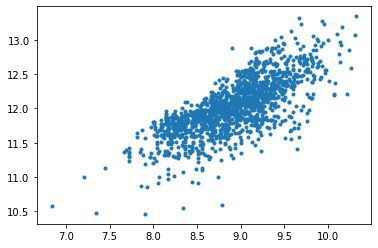

In [136]:
plt.plot(df['GrLivArea'], df['log_SalePrice'], '.')

In [137]:
log_train_sale_price = np.log1p(train_sale_price)

In [138]:
train = all_data.iloc[:train.shape[0], :]
test = all_data.iloc[train.shape[0]:, :]

outliers_index = log_train_sale_price[log_train_sale_price<10.6].index
train = train.drop(outliers_index, axis=0).reset_index(drop=True)
log_train_sale_price = log_train_sale_price.drop(outliers_index).reset_index(drop=True)
print ('new train data: ', train.shape)
print ('new test data: ', test.shape)

new train data:  (1451, 330)
new test data:  (1459, 330)


In [139]:
X = train
y = log_train_sale_price

## Simple model

In [140]:
k = 10
#kfolds = KFold(n_splits=k, shuffle=True, random_state=20)
def cv_error(model):
    errors = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=k))
    return (errors)

In [141]:
def get_error(actual_y, predict_y):
    error = np.sqrt(mean_squared_error(actual_y, predict_y))
    return (error)

In [142]:
def submission_file(model_name, predict_test, err):
    submission = pd.DataFrame()
    submission['Id'] = test_Id 
    submission['SalePrice'] = np.expm1(predict_test)
    file = model_name + '_' + str(round(err,5)) + '.csv'
    return (submission, file)

#### Lasso

In [143]:
'''min_error = 1.0
for alpha in [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001]:
    lasso = make_pipeline(RobustScaler(), Lasso(alpha=alpha, max_iter=5000))
    #lasso = make_pipeline(RobustScaler(), Lasso(alpha=alpha, max_iter=10000))
    error = cv_error(lasso).mean()
    std = cv_error(lasso).std()
    print ('alpha={}, error={:.5f}, std={:.5f}'.format(alpha, error, std))
    if error < min_error:
        min_error = error
        min_std = std
        fit_alpha = alpha        
        lasso_model = lasso
print ('Lasso model: {}\nalpha = {}, error = {:.5f}, std={:.5f}'.format(lasso_model, fit_alpha, min_error, min_std))'''

"min_error = 1.0\nfor alpha in [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001]:\n    lasso = make_pipeline(RobustScaler(), Lasso(alpha=alpha, max_iter=5000))\n    #lasso = make_pipeline(RobustScaler(), Lasso(alpha=alpha, max_iter=10000))\n    error = cv_error(lasso).mean()\n    std = cv_error(lasso).std()\n    print ('alpha={}, error={:.5f}, std={:.5f}'.format(alpha, error, std))\n    if error < min_error:\n        min_error = error\n        min_std = std\n        fit_alpha = alpha        \n        lasso_model = lasso\nprint ('Lasso model: {}\nalpha = {}, error = {:.5f}, std={:.5f}'.format(lasso_model, fit_alpha, min_error, min_std))"

In [144]:
lasso_alpha = [0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
lasso = make_pipeline(RobustScaler(), LassoCV(alphas=lasso_alpha, max_iter=10000, cv=k))
error = cv_error(lasso).mean()
std = cv_error(lasso).std()
#print ('Lasso model: {}'.format(lasso))
print ('error={:.5f}, std={:.5f}'.format(error, std))
#error=0.10280, std=0.01443

error=0.10280, std=0.01443


In [145]:
lasso.fit(X, y)
lasso_predict_y = lasso.predict(X)
train_set_err = get_error(y, lasso_predict_y)
print('train set error: {:.5f}'.format(train_set_err))
lasso_predict_test = lasso.predict(test)
#train set error: 0.09210

train set error: 0.09210


In [146]:
lasso_submission, lasso_file = submission_file('lasso', lasso_predict_test, train_set_err)
print (lasso_file)

lasso_0.0921.csv


In [147]:
lasso_submission.to_csv(lasso_file, index=False)

#### Ridge

In [148]:
'''min_error = 1.0
for alpha in [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 50, 100]:
    ridge = make_pipeline(RobustScaler(), Ridge(alpha=alpha))
    error = cv_error(ridge).mean()
    std = cv_error(ridge).std()
    print ('alpha={}, error={:.5f}, std={:.5f}'.format(alpha, error, std))
    if error <= min_error:
        min_error = error
        min_std = std
        fit_alpha = alpha        
        ridge_model = ridge
print ('Ridge model: {}\nalpha = {}, error = {:.5f}, std={:.5f}'.format(ridge_model, fit_alpha, min_error, min_std))'''

"min_error = 1.0\nfor alpha in [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 50, 100]:\n    ridge = make_pipeline(RobustScaler(), Ridge(alpha=alpha))\n    error = cv_error(ridge).mean()\n    std = cv_error(ridge).std()\n    print ('alpha={}, error={:.5f}, std={:.5f}'.format(alpha, error, std))\n    if error <= min_error:\n        min_error = error\n        min_std = std\n        fit_alpha = alpha        \n        ridge_model = ridge\nprint ('Ridge model: {}\nalpha = {}, error = {:.5f}, std={:.5f}'.format(ridge_model, fit_alpha, min_error, min_std))"

In [149]:
#ridge_alpha = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
#ridge_alpha = [10, 15, 20, 50, 100, 200, 300, 400, 500]
ridge_alpha = [14, 14.5, 15, 15.5, 16]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alpha, cv=k))
error = cv_error(ridge).mean()
std = cv_error(ridge).std()
#print ('Ridge model: {}'.format(ridge))
print ('error={:.5f}, std={:.5f}'.format(error, std))
#error=0.10390, std=0.01363

error=0.10390, std=0.01363


In [150]:
ridge.fit(X, y)
ridge_predict_y = ridge.predict(X)
train_set_err = get_error(y, ridge_predict_y)
print('train set error: {:.5f}'.format(train_set_err))
ridge_predict_test = ridge.predict(test)
#train set error: 0.09022

train set error: 0.09022


In [151]:
ridge_submission, ridge_file = submission_file('ridge', ridge_predict_test, train_set_err)
print (ridge_file)

ridge_0.09022.csv


In [152]:
ridge_submission.to_csv(ridge_file, index=False)

#### ElasticNet

In [153]:
'''min_error = 1.0
min_std = 0.1
for alpha in [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001]:
#for alpha in [0.0001, 0.0005, 0.001]:
    for ratio in [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]:
    #for ratio in [0.7]:
        #enet = make_pipeline(RobustScaler(), ElasticNet(alpha=alpha, l1_ratio=ratio, max_iter=5000))
        enet = make_pipeline(RobustScaler(), ElasticNet(alpha=alpha, l1_ratio=ratio, max_iter=10000))
        error = cv_error(enet).mean()
        std = cv_error(enet).std()
        print ('ratio={}, alpha={}, error={:.5f}, std={:.5f}'.format(ratio, alpha, error, std))
        if error < min_error or std<min_std:
            min_error = error
            min_std = std
            fit_alpha = alpha    
            fit_ratio = ratio
            enet_model = enet
print ('ElasticNet model: {}\nl1_ratio={}, alpha = {}, error = {:.5f}, std={:.5f}'.format(
    enet_model, fit_ratio, fit_alpha, min_error, min_std))'''
#ratio=0.7, alpha=0.0005, error=0.10251, std=0.01443
#ratio=0.5, alpha=0.0007, error=0.10251, std=0.01442
#ratio=0.5, alpha=0.0008, error=0.10251, std=0.01439

"min_error = 1.0\nmin_std = 0.1\nfor alpha in [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001]:\n#for alpha in [0.0001, 0.0005, 0.001]:\n    for ratio in [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]:\n    #for ratio in [0.7]:\n        #enet = make_pipeline(RobustScaler(), ElasticNet(alpha=alpha, l1_ratio=ratio, max_iter=5000))\n        enet = make_pipeline(RobustScaler(), ElasticNet(alpha=alpha, l1_ratio=ratio, max_iter=10000))\n        error = cv_error(enet).mean()\n        std = cv_error(enet).std()\n        print ('ratio={}, alpha={}, error={:.5f}, std={:.5f}'.format(ratio, alpha, error, std))\n        if error < min_error or std<min_std:\n            min_error = error\n            min_std = std\n            fit_alpha = alpha    \n            fit_ratio = ratio\n            enet_model = enet\nprint ('ElasticNet model: {}\nl1_ratio={}, alpha = {}, error = {:.5f}, std={:.5f}'.format(\n    enet_model, fit_ratio, fit_alpha, min_error, min_std))"

In [154]:
enet_alpha = [0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009]
ratio = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]  
enet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=10000, alphas=enet_alpha, cv=k, l1_ratio=ratio))
error = cv_error(enet).mean()
std = cv_error(enet).std()
#print ('ElasticNet model: {}'.format(enet))
print ('error={:.5f}, std={:.5f}'.format(error, std))
#error=0.10288, std=0.01438

error=0.10288, std=0.01438


In [155]:
enet.fit(X,y)
enet_predict_y = enet.predict(X)
train_set_err = get_error(y, enet_predict_y)
print('train set error: {:.5f}'.format(train_set_err))
enet_predict_test = enet.predict(test)
#train set error: 0.09159

train set error: 0.09159


In [156]:
enet_submission, enet_file = submission_file('enet', enet_predict_test, train_set_err)
print (enet_file)

enet_0.09159.csv


In [187]:
enet_submission.to_csv(enet_file, index=False)

#### SVR

In [158]:
#for 

In [159]:
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))
error = cv_error(svr).mean()
std = cv_error(svr).std()
#print ('SVR model: {}'.format(enet))
print ('error={:.5f}, std={:.5f}'.format(error, std))
#error=0.10292, std=0.01619

error=0.10292, std=0.01619


In [160]:
svr.fit(X,y)
svr_predict_y = svr.predict(X)
train_set_err = get_error(y, svr_predict_y)
print('train set error: {:.5f}'.format(train_set_err))
svr_predict_test = svr.predict(test)
#train set error: 0.08048

train set error: 0.08048


In [161]:
svr_submission, svr_file = submission_file('svr', svr_predict_test, train_set_err)
print (svr_file)

svr_0.08048.csv


In [162]:
svr_submission.to_csv(svr_file, index=False)

#### Gradient Boosting Regression

In [163]:
'''gb = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05, max_depth=3, 
                                max_features='sqrt', min_samples_leaf=15, min_samples_split=10, 
                                loss='huber')                             
error = cv_error(gb).mean()
std = cv_error(gb).std()
print ('Gradient Boost model: {}'.format(gb))
print ('error={:.5f}, std={:.5f}'.format(error, std))'''

"gb = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05, max_depth=3, \n                                max_features='sqrt', min_samples_leaf=15, min_samples_split=10, \n                                loss='huber')                             \nerror = cv_error(gb).mean()\nstd = cv_error(gb).std()\nprint ('Gradient Boost model: {}'.format(gb))\nprint ('error={:.5f}, std={:.5f}'.format(error, std))"

In [164]:
gb = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, 
                                max_features='sqrt', min_samples_leaf=15, min_samples_split=10, 
                                loss='huber')                             
error = cv_error(gb).mean()
std = cv_error(gb).std()
print ('Gradient Boost model: {}'.format(gb))
print ('error={:.5f}, std={:.5f}'.format(error, std))
#error=0.10597, std=0.01570

Gradient Boost model: GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.05, loss='huber', max_depth=4,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=15, min_samples_split=10,
                          min_weight_fraction_leaf=0.0, n_estimators=3000,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
error=0.10766, std=0.01607


In [165]:
gb.fit(X,y)
gb_predict_y = gb.predict(X)
train_set_err = get_error(y, gb_predict_y)
print('train set error: {:.5f}'.format(train_set_err))
gb_predict_test = gb.predict(test)
#train set error: 0.04412

train set error: 0.04436


In [166]:
gb_submission, gb_file = submission_file('gb', gb_predict_test, train_set_err)
print (gb_file)

gb_0.04436.csv


In [167]:
gb_submission.to_csv(gb_file, index=False)

#### XGBoost Regression

In [168]:
xgb = XGBRegressor(learning_rate=0.05, n_estimators=3000, max_depth=3, 
                   colsample_bytree=0.7, objective='reg:squarederror',
                   nthread=-1, min_child_weight=0, gamma=0, subsample=0.7, 
                   scale_pos_weight=1, seed=27, reg_alpha=0.00006)
error = cv_error(xgb).mean()
std = cv_error(xgb).std()
print ('XGBoost model: {}'.format(xgb))
print ('error={:.5f}, std={:.5f}'.format(error, std))
#error=0.10858, std=0.01381
#error=0.10851, std=0.01467

//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-pack

XGBoost model: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=0, missing=None, n_estimators=3000,
             n_jobs=1, nthread=-1, objective='reg:squarederror', random_state=0,
             reg_alpha=6e-05, reg_lambda=1, scale_pos_weight=1, seed=27,
             silent=None, subsample=0.7, verbosity=1)
error=0.10851, std=0.01467


In [169]:
xgb.fit(X,y)
xgb_predict_y = xgb.predict(X)
train_set_err = get_error(y, xgb_predict_y)
print('train set error: {:.5f}'.format(train_set_err))
xgb_predict_test = xgb.predict(test)
#train set error: 0.01078

//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


train set error: 0.01078


In [170]:
xgb_submission, xgb_file = submission_file('xgb', xgb_predict_test, train_set_err)
print (xgb_file)

xgb_0.01078.csv


In [171]:
xgb_submission.to_csv(xgb_file, index=False)

In [172]:
'''xgb = XGBRegressor(learning_rate=0.05, n_estimators=3000, max_depth=3, 
                   colsample_bytree=0.7,
                   objective='reg:squarederror',
                   nthread=-1, min_child_weight=0, gamma=0, subsample=0.7, 
                   scale_pos_weight=1, seed=27, reg_alpha=0.00006)
error = cv_error(xgb).mean()
std = cv_error(xgb).std()
print ('XGBoost model: {}'.format(xgb))
print ('error={:.5f}, std={:.5f}'.format(error, std))  
#error=0.10851, std=0.01467
xgb.fit(X,y)
xgb_predict_y = xgb.predict(X)
train_set_err = get_error(y, xgb_predict_y)
print('train set error: {:.5f}'.format(train_set_err))
xgb_predict_test = xgb.predict(test)
#train set error: 0.05238'''

"xgb = XGBRegressor(learning_rate=0.05, n_estimators=3000, max_depth=3, \n                   colsample_bytree=0.7,\n                   objective='reg:squarederror',\n                   nthread=-1, min_child_weight=0, gamma=0, subsample=0.7, \n                   scale_pos_weight=1, seed=27, reg_alpha=0.00006)\nerror = cv_error(xgb).mean()\nstd = cv_error(xgb).std()\nprint ('XGBoost model: {}'.format(xgb))\nprint ('error={:.5f}, std={:.5f}'.format(error, std))  \n#error=0.10851, std=0.01467\nxgb.fit(X,y)\nxgb_predict_y = xgb.predict(X)\ntrain_set_err = get_error(y, xgb_predict_y)\nprint('train set error: {:.5f}'.format(train_set_err))\nxgb_predict_test = xgb.predict(test)\n#train set error: 0.05238"

#### Mean pedictions

In [173]:
predict_y_mean = np.stack((lasso_predict_y, ridge_predict_y, enet_predict_y,
                           svr_predict_y, gb_predict_y, xgb_predict_y), axis=-1)
predict_y_mean = np.mean(predict_y_mean, axis=1)
mean_err = get_error(y, predict_y_mean)
print('{:.5f}'.format(mean_err))
#0.06467

0.06473


In [174]:
predict_test_mean = np.stack((lasso_predict_test, ridge_predict_test, enet_predict_test,
                         svr_predict_test, gb_predict_test, xgb_predict_test), axis=-1)
predict_test_mean = np.mean(predict_test_mean, axis=1)

In [175]:
mean_submission, mean_file = submission_file('mean', predict_test_mean, mean_err)
print (mean_file)

mean_0.06473.csv


In [176]:
mean_submission.to_csv(mean_file, index=False)

### Meta model

In [219]:
stack = StackingCVRegressor(regressors=(lasso, ridge, enet, svr, gb, xgb),
                            meta_regressor=lasso,
                            use_features_in_secondary=True)

In [220]:
stack.fit(np.array(X), np.array(y))
stack_predict_y = stack.predict(np.array(X))
stack_err = get_error(y, stack_predict_y)
print('{:.5f}'.format(stack_err))
stack_predict_test = stack.predict(np.array(test))
#0.05855
#0.04906
#lasso: 0.06850

0.06020


In [221]:
stack_submission, stack_file = submission_file('lasso_stack', stack_predict_test, stack_err)
print (stack_file)

lasso_stack_0.0602.csv


In [222]:
stack_submission.to_csv(stack_file, index=False)

In [223]:
w = [0.16, 0.16, 0.2, 0.12, 0.12, 0.12, 0.12]   #0.06508
#w = [0.16, 0.09, 0.15, 0.09, 0.1, 0.16, 0.25]
sum(w)

1.0

In [224]:
blend_y =  (w[0] * lasso_predict_y + \
            w[1] * ridge_predict_y + \
            w[2] * enet_predict_y + \
            w[3] * svr_predict_y + \
            w[4] * gb_predict_y + \
            w[5] * xgb_predict_y + \
            w[6] * stack_predict_y)
blend_err = get_error(y, blend_y)
print('{:.5f}'.format(blend_err))
#0.06508

0.06810


In [225]:
blend_test =  (w[0] * lasso_predict_test + \
            w[1] * ridge_predict_test + \
            w[2] * enet_predict_test + \
            w[3] * svr_predict_test + \
            w[4] * gb_predict_test + \
            w[5] * xgb_predict_test + \
            w[6] * stack_predict_test)

In [226]:
blend_submission = pd.DataFrame()
blend_submission['Id'] = test_Id 
blend_submission['SalePrice'] = np.expm1(blend_test)
blend_file = 'blend_submission_' + str(round(blend_err,5)) + '.csv'
print(blend_file)

blend_submission_0.0681.csv


In [227]:
blend_submission, stack_file = submission_file('blend', blend_test, blend_err)
print (blend_file)

blend_submission_0.0681.csv


In [228]:
blend_submission.to_csv(blend_file, index=False)